# Image Reconstruction: Linear Regression

Identifies masked regions in images, divides them into subregions, predicts pixel values, and evaluates reconstruction results.

In [1]:
import os
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from PIL import Image # New
import math # New

## Locate Black Region

Identifies the bounding box of the black region in an image based on pixel values. A region is valid if it contains more than a specified threshold of black pixels.

In [2]:
# def locate_black_region(masked_image, threshold=20):
#     """
#     Identifies the bounding box of the black region in the masked image.
#     Ensures accurate detection by checking for black pixels explicitly.
#     """
#     # Identify black pixels (threshold for very dark colors)
#     black_pixels = np.where((masked_image[:, :, 0] == 0) & 
#                             (masked_image[:, :, 1] == 0) & 
#                             (masked_image[:, :, 2] == 0))
# 
#     if len(black_pixels[0]) > threshold:
#         y_start, y_end = np.min(black_pixels[0]), np.max(black_pixels[0]) + 1
#         x_start, x_end = np.min(black_pixels[1]), np.max(black_pixels[1]) + 1
#         return x_start, y_start, x_end, y_end
#     else:
#         return None
    
# New
# Corrected function with precise 3-pixel padding applied evenly
def find_black_rectangle(image: np.ndarray, threshold: float = 0.15, padding: int = 3):
    """
    Finds the largest black rectangular region in an RGB image with precise padding.

    Args:
        image (numpy.ndarray): Input image array with shape (H, W, 3).
        threshold (float, optional): Blackness threshold for all three RGB channels. Default is 0.05.
        padding (int, optional): Fixed padding to apply evenly around the rectangle. Default is 3 pixels.

    Returns:
        tuple: Coordinates of the largest black rectangle with padding (y_min, y_max, x_min, x_max).
    """
    # Convert image to binary mask where black pixels are True
    black_mask = np.all(image < threshold, axis=-1)

    H, W = black_mask.shape
    largest_area = 0
    best_coords = None

    # DP table to store largest rectangle widths
    dp_width = np.zeros((H, W), dtype=int)

    for y in range(H):
        for x in range(W):
            # Calculate widths of black regions
            if black_mask[y, x]:
                dp_width[y, x] = dp_width[y, x - 1] + 1 if x > 0 else 1

            # Check for the largest rectangle ending at (y, x)
            width = dp_width[y, x]
            for k in range(y, -1, -1):  # Iterate upward to calculate height
                width = min(width, dp_width[k, x])
                if width == 0:
                    break
                height = y - k + 1
                area = width * height
                if area > largest_area:
                    largest_area = area
                    best_coords = (k, y, x - width + 1, x)

    # Ensure valid coordinates
    if best_coords is None:
        return (0, 0, 0, 0)  # No black rectangle found

    y_min, y_max, x_min, x_max = best_coords

    # Apply precise padding of 3 pixels evenly
    y_min = max(0, y_min - padding)
    y_max = min(H, y_max + padding)
    x_min = max(0, x_min - padding)
    x_max = min(W, x_max + padding)

    return y_min, y_max, x_min, x_max

## Split Region

Divides the identified black region into smaller subregions for localized processing.

In [3]:
def split_region(x_start, y_start, x_end, y_end, num_splits=4):
    """
    Divides the black region into smaller subregions.
    Returns a list of bounding boxes for each subregion.
    """
    subregions = []
    height = y_end - y_start
    width = x_end - x_start

    num_rows = int(np.sqrt(num_splits))  # Number of rows/columns to divide into
    step_y = height // num_rows
    step_x = width // num_rows

    for i in range(num_rows):
        for j in range(num_rows):
            sub_x_start = x_start + j * step_x
            sub_y_start = y_start + i * step_y
            sub_x_end = sub_x_start + step_x
            sub_y_end = sub_y_start + step_y
            subregions.append((sub_x_start, sub_y_start, sub_x_end, sub_y_end))

    return subregions

## Merge Training and Validation Datasets

Merges the training and validation datasets into a single directory for training.

In [4]:
def merge_datasets(train_dir, validation_dir):
    """
    Reads images from both the training and validation directories.
    Combines their data into a single set for processing without modifying the files.
    """
    combined_files = []

    # Read training directory
    for filename in sorted(os.listdir(train_dir)):
        if filename.endswith("_masked.jpg"):
            combined_files.append((train_dir, filename))

    # Read validation directory
    for filename in sorted(os.listdir(validation_dir)):
        if filename.endswith("_masked.jpg"):
            combined_files.append((validation_dir, filename))

    return combined_files

## Prepare Training Data

Extracts features (surrounding pixel coordinates) and targets (pixel values) from the training dataset for use in regression.

In [5]:
def prepare_training_data(train_dir):
    """
    Prepares training data by extracting surrounding pixel coordinates and
    their RGB values as features. Targets are the mean RGB color of the black region.
    """
    features = []
    features0 = [] # New
    features1 = [] # New
    features2 = [] # New
    features3 = [] # New
    
    targets = []
    targets0 = [] # New
    targets1 = [] # New
    targets2 = [] # New
    targets3 = [] # New

    for filename in sorted(os.listdir(train_dir)):
        if filename.endswith("_masked.jpg"):
            masked_image_path = os.path.join(train_dir, filename)
            original_image_path = masked_image_path.replace("_masked", "")

            masked_image = Image.open(masked_image_path).convert("RGB") # New
            original_image = Image.open(original_image_path).convert("RGB") # New
            
            # Convert images to NumPy arrays
            original_array = np.array(original_image).astype(np.float32) / 255.0 # New
            mask_array = np.array(masked_image).astype(np.float32) / 255.0 # New
            
            y_min, y_max, x_min, x_max = find_black_rectangle(mask_array) # New
            
            # Calculate mean RGB color of the black square region
            subregions = split_region(x_min, y_min, x_max, y_max)
            subregions_means = [] # New
            mean_colors = [] # New      
            
            # New
            for sub_x_start, sub_y_start, sub_x_end, sub_y_end in subregions:
                region = original_array[sub_y_start:sub_y_end, sub_x_start:sub_x_end]
                mean_colors.append(region.mean(axis=(0, 1))) # Mean RGB values (R, G, B)
                
                x_cordinate = abs(sub_x_start-sub_x_end) + min(sub_x_start, sub_x_end)
                y_cordinate = abs(sub_y_start-sub_y_end) + min(sub_y_start, sub_y_end)
                subregions_means.append([x_cordinate, y_cordinate])
                
                                    
            # Extract surrounding pixel coordinates
            for x in range(x_min - 1, x_max + 2):
                for y in range(y_min - 1, y_max + 2):
                    if (
                        0 <= x < original_array.shape[1] # New
                        and 0 <= y < original_array.shape[0] # New
                    ):
                        if not (x_min <= x < x_max and y_min <= y < y_max):
                            # New
                            min_dist = float('inf')
                            num_region = 0
                            i = 0
                            for x_cord, y_cord in subregions_means:
                                distance = math.sqrt((x_cord-x)**2 + (y_cord-y)**2)
                                if distance < min_dist:
                                    min_dist = distance
                                    num_region = i
                                
                                i += 1
                    
                            if num_region == 0:
                                features0.append([x, y])
                                targets0.append(mean_colors[num_region])
                            elif num_region == 1:
                                features1.append([x, y])
                                targets1.append(mean_colors[num_region])
                            elif num_region == 2:
                                features2.append([x, y])
                                targets2.append(mean_colors[num_region])
                            elif num_region == 3:
                                features3.append([x, y])
                                targets3.append(mean_colors[num_region])
    
    # New
    features.append(np.array(features0))
    features.append(np.array(features1))
    features.append(np.array(features2))
    features.append(np.array(features3))
    
    targets.append(np.array(targets0))
    targets.append(np.array(targets1))
    targets.append(np.array(targets2))
    targets.append(np.array(targets3))

    return features, targets

## Train Regression Model

Trains a linear regression model using the prepared training data.

In [6]:
# New
def train_regression_model(features, targets):
    """
    Trains three separate linear regression models (one for each RGB channel)
    using the provided features and targets.
    Returns the weights for each channel.
    """
    # Separate RGB channels for each subregion
    targets_r0 = targets[0][:, 0]
    targets_g0 = targets[0][:, 1]
    targets_b0 = targets[0][:, 2]
    
    targets_r1 = targets[1][:, 0]
    targets_g1 = targets[1][:, 1]
    targets_b1 = targets[1][:, 2]
    
    targets_r2 = targets[2][:, 0]
    targets_g2 = targets[2][:, 1]
    targets_b2 = targets[2][:, 2]
    
    targets_r3 = targets[3][:, 0]
    targets_g3 = targets[3][:, 1]
    targets_b3 = targets[3][:, 2]
    
    features0 = features[0]
    features1 = features[1]
    features2 = features[2]
    features3 = features[3]
    
    weights_r = []
    weights_g = []
    weights_b = []

    # Train regressions for each channel for each subregion
    weights_r0 = np.linalg.lstsq(features0, targets_r0, rcond=None)[0]
    weights_g0 = np.linalg.lstsq(features0, targets_g0, rcond=None)[0]
    weights_b0 = np.linalg.lstsq(features0, targets_b0, rcond=None)[0]
    
    weights_r1 = np.linalg.lstsq(features1, targets_r1, rcond=None)[0]
    weights_g1 = np.linalg.lstsq(features1, targets_g1, rcond=None)[0]
    weights_b1 = np.linalg.lstsq(features1, targets_b1, rcond=None)[0]
    
    weights_r2 = np.linalg.lstsq(features2, targets_r2, rcond=None)[0]
    weights_g2 = np.linalg.lstsq(features2, targets_g2, rcond=None)[0]
    weights_b2 = np.linalg.lstsq(features2, targets_b2, rcond=None)[0]

    weights_r3 = np.linalg.lstsq(features3, targets_r3, rcond=None)[0]
    weights_g3 = np.linalg.lstsq(features3, targets_g3, rcond=None)[0]
    weights_b3 = np.linalg.lstsq(features3, targets_b3, rcond=None)[0]
    
    weights_r.append(weights_r0)
    weights_r.append(weights_r1)
    weights_r.append(weights_r2)
    weights_r.append(weights_r3)
    
    weights_g.append(weights_g0)
    weights_g.append(weights_g1)
    weights_g.append(weights_g2)
    weights_g.append(weights_g3)
    
    weights_b.append(weights_b0)
    weights_b.append(weights_b1)
    weights_b.append(weights_b2)
    weights_b.append(weights_b3)

    return weights_r, weights_g, weights_b

## Perform Regression

Predicts pixel values in a black region based on surrounding pixel information using a linear regression implementation.

In [7]:
# Unused function
# def perform_regression(original, region_coords):
#     """
#     Predicts pixel values in the black region using linear regression on surrounding pixels.
#     """
#     x_start, y_start, x_end, y_end = region_coords
# 
#     surrounding_pixels = []
#     surrounding_values = []
#     for x in range(x_start - 1, x_end + 2):
#         for y in range(y_start - 1, y_end + 2):
#             if not (x_start <= x < x_end and y_start <= y < y_end):
#                 surrounding_pixels.append([x, y])
#                 surrounding_values.append(original[y, x])
# 
#     surrounding_pixels = np.array(surrounding_pixels)
#     surrounding_values = np.array(surrounding_values)
# 
#     region_pixels = []
#     for x in range(x_start, x_end):
#         for y in range(y_start, y_end):
#             region_pixels.append([x, y])
# 
#     region_pixels = np.array(region_pixels)
# 
#     weights = np.linalg.lstsq(surrounding_pixels, surrounding_values, rcond=None)[0]
#     predicted_values = np.dot(region_pixels, weights)
# 
#     reconstructed_region = np.zeros((y_end - y_start, x_end - x_start, 3), dtype=np.uint8)
#     index = 0
#     for y in range(reconstructed_region.shape[0]):
#         for x in range(reconstructed_region.shape[1]):
#             reconstructed_region[y, x] = predicted_values[index]
#             index += 1
# 
#     return reconstructed_region

## Evaluate Reconstruction

Compares reconstructed images to the original images using mean squared error (MSE) and mean absolute error (MAE).

In [8]:
def evaluate_reconstruction(original, reconstructed):
    """
    Computes MSE and MAE between the original and reconstructed images.
    """
    mse = mean_squared_error(original.flatten(), reconstructed.flatten())
    mae = mean_absolute_error(original.flatten(), reconstructed.flatten())
    return mse, mae

## Process Test Dataset

Processes a directory of images by identifying and reconstructing masked regions.

In [9]:
def process_test_data(test_dir, weights_r, weights_g, weights_b):
    """
    Processes test images and reconstructs black regions using the trained model.
    Splits the black region into 4 subregions and reconstructs each separately.
    """
    original_images = []
    masked_images = []
    reconstructed_images = []

    for filename in sorted(os.listdir(test_dir)):
        if filename.endswith("_masked.jpg"):
            masked_image_path = os.path.join(test_dir, filename)
            original_image_path = masked_image_path.replace("_masked", "")

            masked_image = Image.open(masked_image_path).convert("RGB") # New 
            original_image = Image.open(original_image_path).convert("RGB") # New 
            
            # Convert images to NumPy arrays
            original_array = np.array(original_image).astype(np.float32) / 255.0 # New 
            mask_array = np.array(masked_image).astype(np.float32) / 255.0 # New 
            
            y_min, y_max, x_min, x_max = find_black_rectangle(mask_array) # New

            reconstructed_image = mask_array.copy() # New

            # Split black region into 4 subregions
            subregions = split_region(x_min, y_min, x_max, y_max, num_splits=4) # New
            for sub_x_start, sub_y_start, sub_x_end, sub_y_end in subregions:
                i = 0 # New
                # Extract surrounding pixels
                surrounding_pixels = []
                for x in range(sub_x_start - 1, sub_x_end + 2):
                    for y in range(sub_y_start - 1, sub_y_end + 2):
                        if (
                            0 <= x < mask_array.shape[1] # New
                            and 0 <= y < mask_array.shape[0] # New
                        ):
                            if not (sub_x_start <= x < sub_x_end and sub_y_start <= y < sub_y_end):
                                surrounding_pixels.append([x, y])

                surrounding_pixels = np.array(surrounding_pixels)

                # Predict mean RGB color for the subregion
                if surrounding_pixels.size > 0:  # Ensure non-empty surrounding pixels
                    mean_r = np.dot(surrounding_pixels, weights_r[i]).mean() # New
                    mean_g = np.dot(surrounding_pixels, weights_g[i]).mean() # New
                    mean_b = np.dot(surrounding_pixels, weights_b[i]).mean() # New
                else:
                    mean_r, mean_g, mean_b = 0, 0, 0  # Default to black if no context
                
                # Ensure proper RGB assignment
                reconstructed_image[sub_y_start:sub_y_end, sub_x_start:sub_x_end, 0] = mean_r  # Red
                reconstructed_image[sub_y_start:sub_y_end, sub_x_start:sub_x_end, 1] = mean_g  # Green
                reconstructed_image[sub_y_start:sub_y_end, sub_x_start:sub_x_end, 2] = mean_b  # Blue
            
                i += 1 # New
            
            original_images.append(original_array)
            masked_images.append(mask_array)
            reconstructed_images.append(reconstructed_image)

    return original_images, masked_images, reconstructed_images

## Display Results

Displays the masked and reconstructed images side by side for visual comparison.

In [10]:
def display_results(original_images, masked_images, reconstructed_images):
    """
    Displays masked and reconstructed images in a grid layout for comparison.
    """
    fig, axs = plt.subplots(6, 5, figsize=(15, 18)) # New

    for i in range(10):
        if i < 5:
            axs[0, i].imshow(masked_images[i])
            axs[0, i].axis("off")
            axs[0, i].set_title(f"Masked {i+1}")

            axs[1, i].imshow(reconstructed_images[i])
            axs[1, i].axis("off")
            axs[1, i].set_title(f"Reconstructed {i+1}")
            
            axs[2, i].imshow(original_images[i]) # New
            axs[2, i].axis("off") # New
            axs[2, i].set_title(f"Original {i+1}") # New
        else:
            axs[3, i - 5].imshow(masked_images[i])
            axs[3, i - 5].axis("off")
            axs[3, i - 5].set_title(f"Masked {i+1}")

            axs[4, i - 5].imshow(reconstructed_images[i])
            axs[4, i - 5].axis("off")
            axs[4, i - 5].set_title(f"Reconstructed {i+1}")
            
            axs[5, i - 5].imshow(original_images[i]) # New
            axs[5, i - 5].axis("off") # New
            axs[5, i - 5].set_title(f"Original {i+1}") # New

    plt.tight_layout()
    plt.show()

## Run the Reconstruction Workflow

Combines all functions to train the model using the training dataset and reconstruct masked regions in the test dataset.

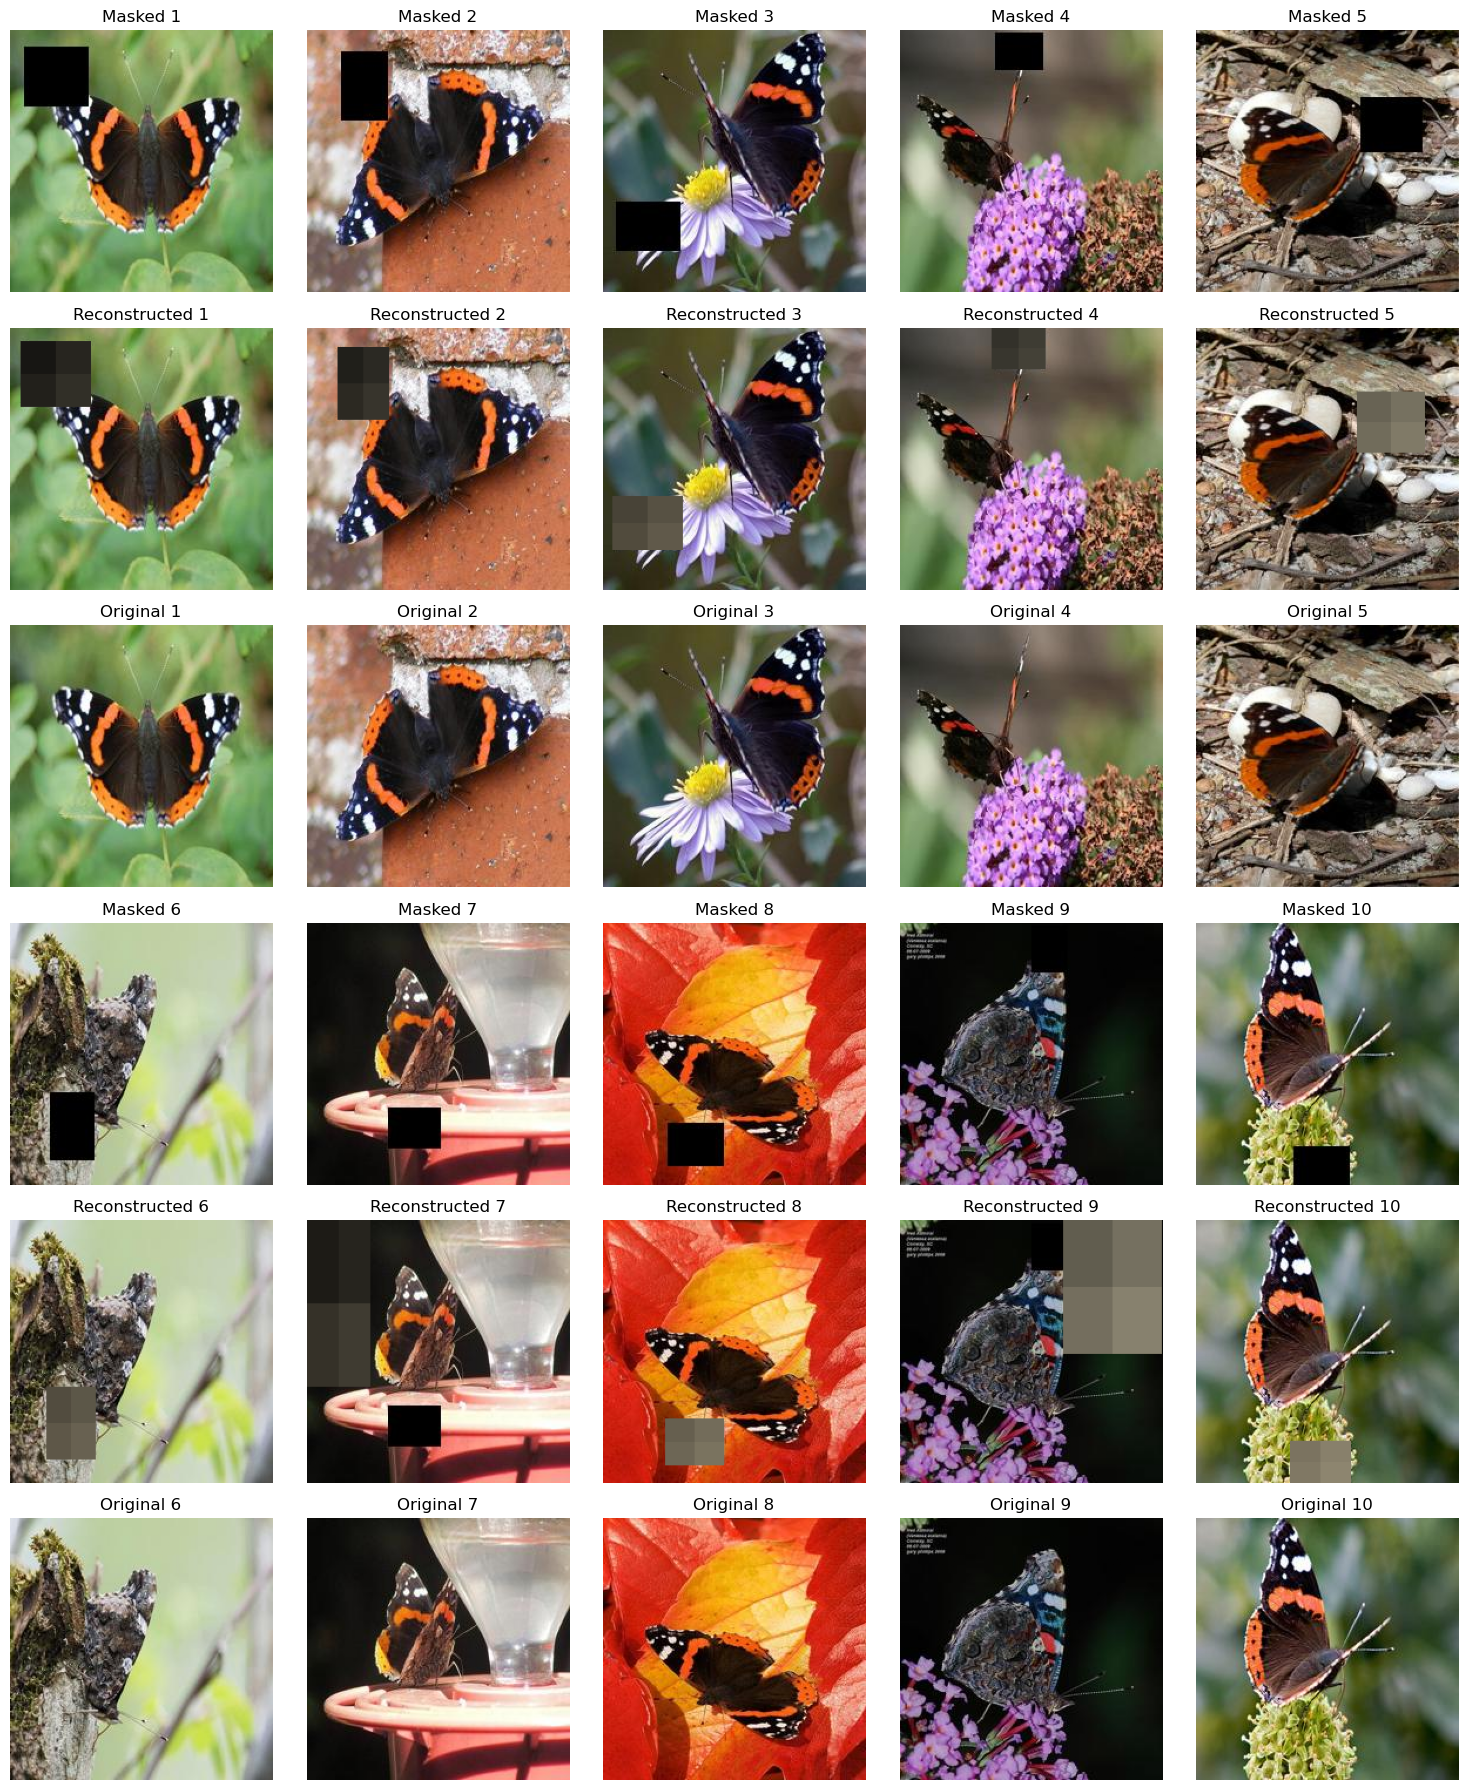

In [11]:
# Paths to dataset directories
train_dir = "Dataset/train"
validation_dir = "Dataset/validation"
test_dir = "Dataset/test"

# Prepare training data
features, targets = prepare_training_data(train_dir)

# Train regression model
weights_r, weights_g, weights_b = train_regression_model(features, targets)

# Process test dataset
original_images, masked_images, reconstructed_images = process_test_data(
    test_dir, weights_r, weights_g, weights_b
)

# Display results
display_results(original_images, masked_images, reconstructed_images)